In [39]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
import os
from glob2 import glob
import matplotlib.pyplot as plt

In [5]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [32]:
def process_img(file_path, image_size):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_bmp(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=image_size)
    return img

def build_ds(dir_path, batch_size, image_size):
    files = tf.data.Dataset.from_tensor_slices(glob(os.path.join(dir_path, '*.bmp')))
    return files.map(lambda x: (process_img(x, image_size), process_img(x, image_size))).batch(batch_size)

def build_test_ds(dir_path, batch_size, image_size):
    files = tf.data.Dataset.from_tensor_slices(glob(os.path.join(dir_path, '*.bmp')))
    return files.map(lambda x: (process_img(x, image_size))).batch(batch_size)

In [33]:
n_dir = "./data/nomal"
an_dir = "./data/anomal"
test_dir = "./data/test"
image_size = (200, 200)
batch_size = 64

In [85]:
x_ds = build_ds(n_dir, batch_size, image_size)
y_ds = build_ds(test_dir, batch_size, image_size)
z_ds = build_test_ds(test_dir, batch_size, image_size)
an_ds = build_test_ds(an_dir, batch_size, image_size)
n_ds = build_test_ds(n_dir, batch_size, image_size)

In [9]:
latent_dim = 32


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu"),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(40000, activation='sigmoid'),
            layers.Reshape((200, 200))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder(latent_dim)

In [10]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [97]:
checkpoint_path = "./checkpoint/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

autoencoder.fit(x_ds,
                epochs=5,
                shuffle=True,
                validation_data=y_ds,
                callbacks=[cp_callback])

Epoch 1/5
32/32 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00001: saving model to ./checkpoint\cp.ckpt
32/32 [==============================] - 18s 552ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 2/5
32/32 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00002: saving model to ./checkpoint\cp.ckpt
32/32 [==============================] - 18s 550ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/5
32/32 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00003: saving model to ./checkpoint\cp.ckpt
32/32 [==============================] - 18s 558ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/5
32/32 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00004: saving model to ./checkpoint\cp.ckpt
32/32 [==============================] - 18s 566ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/5
32/32 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00005: saving model to ./checkpoint\cp.ckpt
32/32 [=============

In [35]:
autoencoder.load_weights(checkpoint_path)

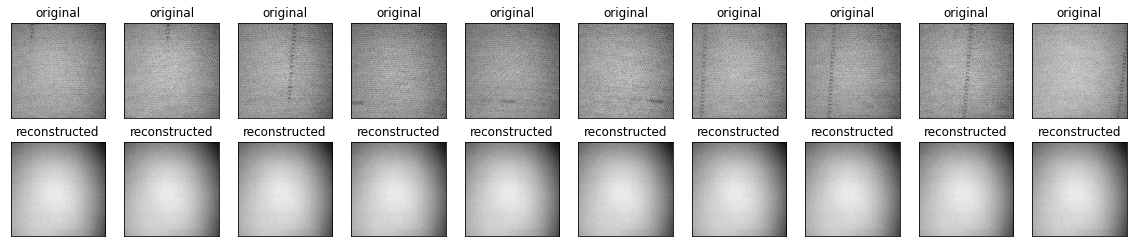

In [40]:
for imgs in z_ds.take(1):
    encoded_imgs = autoencoder.encoder(imgs).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs[i])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

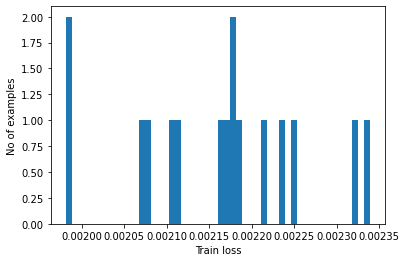

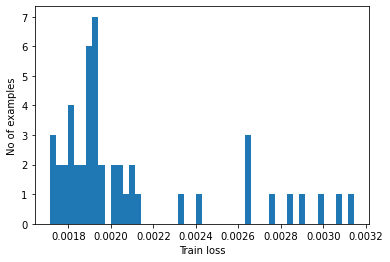

In [99]:

def cal_loss(ds):
    for imgs in ds:
        n = 40
        encoded_imgs = autoencoder.encoder(imgs).numpy()
        recs = autoencoder.decoder(encoded_imgs).numpy()
        mse = [(np.square(rec - img)).mean() for rec, img in zip(recs, imgs)]
    return mse

mse = cal_loss(n_ds)
plt.hist(mse, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

mse = cal_loss(an_ds)
plt.hist(mse, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()



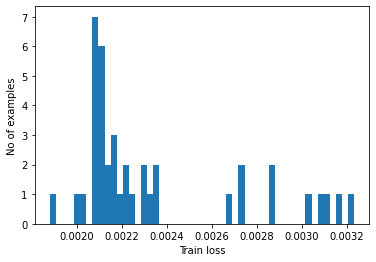

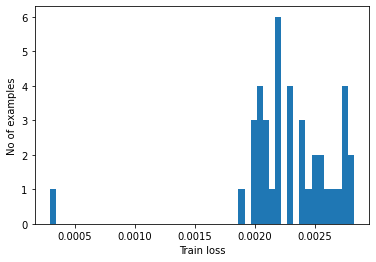

In [96]:
for imgs in n_ds.take(1):
    mse2 = [(np.square(imgs[0] - imgs[i+1])).mean() for i in range(40)]

plt.hist(mse, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

plt.hist(mse2, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()